# Initializations

In [55]:
import gym
import torch
import matplotlib.pyplot as plt
import numpy as np
from copy import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from enum import Enum
from collections import deque
from random import random
from copy import deepcopy
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from operator import add
from torch.distributions.categorical import Categorical
from IPython.display import display, clear_output

In [7]:
torch.cuda.is_available()

False

# Actor-Critic model

## Define actor and critic architectures

In [117]:

class FCNet(nn.Module):

    def __init__(self, input_size, output_size, hsize=100, last_activation=None):
        super(FCNet, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hsize)
        self.fc2 = nn.Linear(hsize, hsize)
        self.fc3 = nn.Linear(hsize, output_size)
        self.last_activation = last_activation
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        if self.last_activation:
            x = F.softmax(self.fc3(x), dim=1)
        else:
            x = self.fc3(x)
        
        return x

In [84]:
outs = torch.rand(7,2)
outs[0][0] = -5
outs[5][1] = 5
print(outs)

outs = F.softmax(outs, dim=1)
print(outs)

tensor([[-5.0000,  0.8546],
        [ 0.5297,  0.6236],
        [ 0.6682,  0.4812],
        [ 0.8287,  0.6060],
        [ 0.5825,  0.2634],
        [ 0.4212,  5.0000],
        [ 0.4417,  0.6794]])
tensor([[0.0029, 0.9971],
        [0.4765, 0.5235],
        [0.5466, 0.4534],
        [0.5554, 0.4446],
        [0.5791, 0.4209],
        [0.0102, 0.9898],
        [0.4408, 0.5592]])


In [85]:
from torch.distributions.categorical import Categorical

dist = Categorical(outs)
dist.log_prob()

TypeError: log_prob() missing 1 required positional argument: 'value'

## Define Q actor-critic agent

In [139]:

class QActorCritic:
    def __init__(self, tau, buffer_size, gamma, actor_lr, critic_lr, state_size, action_size, batch_size,
                 device, warmup_step=1000, hsize=100):

        self.max_buffer_size = buffer_size
        self.gamma = torch.tensor(gamma)
        
        self.buffer = deque()
        self.action_size = action_size
        self.state_size = state_size
        self.batch_size = batch_size
        self.device = device
        self.tau = tau
        
        self.q = FCNet(state_size, action_size, hsize)
        self.q_target = FCNet(state_size, action_size, hsize)
        self.q.to(self.device)
        self.q_target.to(self.device)
        self.critic_opt = optim.Adam(self.q.parameters(), lr=critic_lr)
        
        self.actor = FCNet(state_size, action_size, hsize, last_activation='softmax')
        self.actor.to(self.device)
        self.actor_opt = optim.Adam(self.actor.parameters(), lr=actor_lr)
        
        
        self.update_step = 0
        self.warmup_step = warmup_step
        
        
        
    def get_q_val(self, qnet, state, action=None):
        if action is None:
            return qnet(state)
        return qnet(state).gather(1, action.reshape(-1,1).long())
        
    def add_to_buffer(self, experience):
        if len(self.buffer) >= self.max_buffer_size:
            self.buffer.pop()
        self.buffer.appendleft(experience)
        
    def _np_to_tensor(self, nparrs):
        return [torch.from_numpy(arr).float().to(self.device) for arr in nparrs]
        
    def sample_minibatch(self):
        idxs = np.random.randint(0, len(self.buffer), self.batch_size)
        sample = [self.buffer[i] for i in idxs]
        
        states, actions, rewards, next_states, dones = list(map(lambda x: np.array(x, dtype=np.float64), zip(*sample)))
        return tuple(self._np_to_tensor([states, actions, rewards, next_states, dones]))
        
    def get_action(self, state, det=False):
        """
        if det=False it will sample based on output probabilities of policy function
        """
#         state = torch.from_numpy(state.reshape(-1, self.state_size)).float().to(self.device)
        with torch.no_grad():
            if not det:
                dist = Categorical(self.policy(state))
                actions = dist.sample()
            else:
                actions = torch.argmax(self.policy(state), dim=1)
            
            return actions
        
    def get_single_action(self, state):
        state = torch.from_numpy(state.reshape(-1, self.state_size)).float().to(self.device)
        with torch.no_grad():
            action = torch.argmax(self.policy(state), dim=1)
            
        return action.cpu().numpy()[0]
    
    def policy(self, state):
        return self.actor(state)
    
    def synchronize(self):
        with torch.no_grad():
            params = self.q.parameters()
            targ_params = self.q_target.parameters()
            for p, p_targ in zip(params, targ_params):
                p_targ.data.mul_(1 - self.tau)
                p_targ.data.add_(self.tau * p.data)
        
    def update_critic(self, batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones):
        with torch.no_grad():
            last_step_target = batch_dones * batch_rewards
                        
            next_actions = self.get_action(batch_states, det=False)
            
            middle_step_target = (1-batch_dones)*(batch_rewards + self.gamma*self.get_q_val(self.q, batch_next_states, next_actions).squeeze())
            targets =  last_step_target + middle_step_target
        
        predictions = self.get_q_val(self.q, batch_states, batch_actions).squeeze()
        loss = F.mse_loss(predictions, targets)
        
        self.critic_opt.zero_grad()
        loss.backward()
        self.critic_opt.step()
        
        self.synchronize()
    

    def update_actor(self, batch_states, batch_actions):
        with torch.no_grad():
            q_vals = self.get_q_val(self.q_target, batch_states, batch_actions).squeeze()
            
        action_probs = self.policy(batch_states)
        action_logprobs = Categorical(action_probs).log_prob(batch_actions)
        
        loss = -torch.mean(q_vals*action_logprobs)
        
        self.actor_opt.zero_grad()
        loss.backward()
        self.actor_opt.step()
    
    
    def update(self, state, action, reward, next_state, done):
        self.update_step += 1
    
        self.add_to_buffer([state, action, reward, next_state, done])
        
        #TODO: warmup. should be configurable.
        if len(self.buffer) < self.warmup_step:
            return
        
        batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones = self.sample_minibatch()
        
        self.update_critic(batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones)
        self.update_actor(batch_states, batch_actions)


# Cartpole-v1

## training

In [144]:
def evaluate_det_policy(env, agent, k=100):
    total_rewards = []
    for _ in range(k):
        done = False
        cum_r = 0
        state = env.reset()

        while not done:
            action = agent.get_single_action(state)
            state, reward, done, info = env.step(action)
            cum_r += reward
        
        total_rewards.append(cum_r)
    return total_rewards


def train_and_evaluate(env, agent, epochs, eval_step=100, early_stop_thr=470, eval_it=50):
    
    returns = []
    for i in tqdm(range(epochs)):
        done = False
        state = env.reset()
        
        ret = 0
        while not done:
            a = agent.get_single_action(state)
            next_state, r, done, _ = env.step(a)
            agent.update(state, a, r, next_state, done)
            ret += r
            state = next_state
        done = False
        returns.append(ret)
        
        if int(i+1)%100 == 0:
            avg_ret = np.mean(evaluate_det_policy(env, agent, k=eval_it))
            print(f"epoch:{i} buffer_size:{len(agent.buffer)} average return={avg_ret}")
            if avg_ret > early_stop_thr:
                return returns
            

    return returns



In [146]:
env = gym.make('CartPole-v1')
done = False
state = env.reset()


agent = QActorCritic(
    buffer_size=2000,
    gamma=0.99,
    critic_lr=0.0001,
    actor_lr=0.0001,
    state_size=env.observation_space.shape[0],
    action_size=env.action_space.n,
    batch_size=128,
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    tau=0.999,
    warmup_step=1000,
)


dqn_ret = train_and_evaluate(env, agent, epochs=1000)


  8%|█████████████▉                                                                                                                                                      | 85/1000 [00:00<00:01, 804.31it/s]

epoch:99 buffer_size:1176 average return=15.86


 20%|█████████████████████████████████▏                                                                                                                                  | 202/1000 [00:03<00:14, 55.84it/s]

epoch:199 buffer_size:2000 average return=11.54


 31%|██████████████████████████████████████████████████▏                                                                                                                 | 306/1000 [00:05<00:18, 36.57it/s]

epoch:299 buffer_size:2000 average return=11.68


 40%|██████████████████████████████████████████████████████████████████▍                                                                                                 | 405/1000 [00:08<00:18, 32.30it/s]

epoch:399 buffer_size:2000 average return=11.58


 50%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 503/1000 [00:10<00:13, 36.32it/s]

epoch:499 buffer_size:2000 average return=11.4


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 602/1000 [00:13<00:11, 34.42it/s]

epoch:599 buffer_size:2000 average return=11.22


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 709/1000 [00:16<00:07, 40.83it/s]

epoch:699 buffer_size:2000 average return=11.48


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 809/1000 [00:19<00:04, 40.18it/s]

epoch:799 buffer_size:2000 average return=11.18


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 904/1000 [00:21<00:02, 39.08it/s]

epoch:899 buffer_size:2000 average return=10.74


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 41.30it/s]

epoch:999 buffer_size:2000 average return=10.82


### evaluation graphs

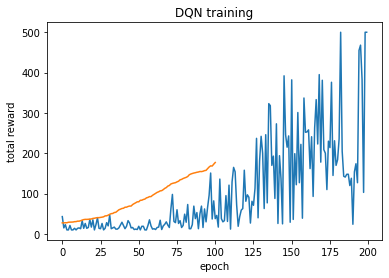

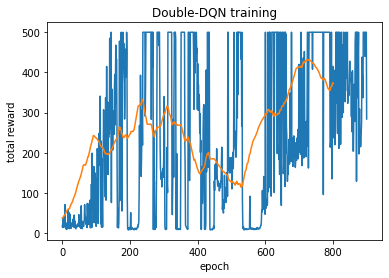

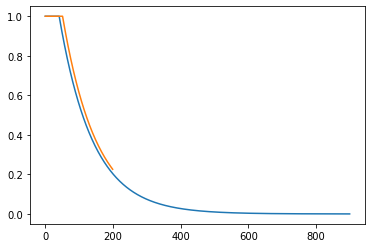

In [20]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


plt.plot(dqn_ret)
plt.plot(moving_average(dqn_ret, n=100))
plt.xlabel('epoch')
plt.ylabel('total reward')
plt.title('DQN training')
plt.show()


plt.plot(ddqn_ret)
plt.plot(moving_average(ddqn_ret, n=100))
plt.xlabel('epoch')
plt.ylabel('total reward')
plt.title('Double-DQN training')
plt.show()

plt.plot(ddqn_eps)
plt.plot(dqn_eps)
plt.show()

### simulating environment

In [23]:
import time

def play(env, agent):
    done = False
    clear_output(wait=True)
    state = env.reset()
    env.render()
    
    while not done:
        action = agent.get_action(state, det=True)
        state, reward, done, info = env.step(action)
        
        clear_output(wait=True)
        print(info)
        env.render()
        time.sleep(0.5)
        
        


In [39]:
play(env, dqn)

{}


2021-11-03 21:01:52.915 python3.8[14168:1455285] TSM AdjustCapsLockLEDForKeyTransitionHandling - _ISSetPhysicalKeyboardCapsLockLED Inhibit


In [ ]:
play(env, ddqn)

### evaluating with deterministic policy

In [21]:
def evaluate_det_policy(env, agent, k=100):
    total_rewards = []
    for _ in range(k):
        done = False
        cum_r = 0
        state = env.reset()

        while not done:
            action = agent.get_action(state, det=True)
            state, reward, done, info = env.step(action)
            cum_r += reward
        
        total_rewards.append(cum_r)
    return total_rewards


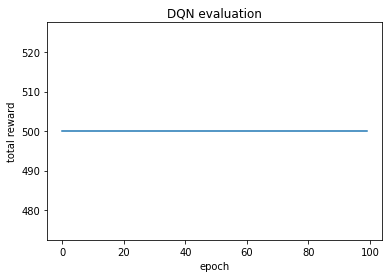

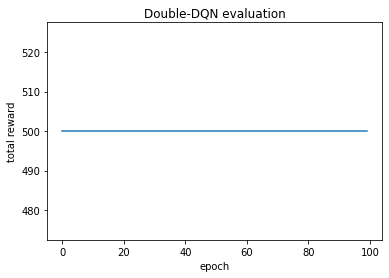

In [22]:
dqn_tot = evaluate_det_policy(env, dqn)
ddqn_tot = evaluate_det_policy(env, ddqn) 

plt.plot(dqn_tot)
plt.xlabel('epoch')
plt.ylabel('total reward')
plt.title('DQN evaluation')
plt.show()


plt.plot(ddqn_tot)
plt.xlabel('epoch')
plt.ylabel('total reward')
plt.title('Double-DQN evaluation')
plt.show()


# LunarLander

## defining agents and training

In [26]:
env = gym.make('LunarLander-v2')
done = False
state = env.reset()


dqn = DqnVannila(
    sync_steps=300,
    buffer_size=10000,
    gamma=0.99,
    lr=3e-4,
    eps=1.0,
    state_size=env.observation_space.shape[0],
    action_size=env.action_space.n,
    batch_size=32,
    eps_decay=0.999,
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    hsize=100,
    min_eps=0.01,
    warmup_step=1000,
)

ddqn = DoubleDQN(
    buffer_size=10000,
    gamma=0.99,
    lr=3e-4,
    eps=1.0,
    state_size=env.observation_space.shape[0],
    action_size=env.action_space.n,
    batch_size=32,
    eps_decay=0.999,
    device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    hsize=100,
    warmup_step=1000,
    min_eps=0.01
)


dqn_ret, dqn_eps = train_and_evaluate(env, dqn, epochs=2000, early_stop_thr=180, eval_it=20)
ddqn_ret, ddqn_eps = train_and_evaluate(env, ddqn, epochs=2000, early_stop_thr=180, eval_it=20)

  5%|████████                                                                                                                                                          | 100/2000 [00:26<1:55:09,  3.64s/it]

epoch:99 average return=-92.39986151160699


 10%|████████████████▎                                                                                                                                                 | 202/2000 [01:01<1:41:13,  3.38s/it]

epoch:199 average return=-64.36356675551453


 15%|████████████████████████▍                                                                                                                                         | 301/2000 [01:28<1:26:54,  3.07s/it]

epoch:299 average return=-111.59206048090513


 20%|████████████████████████████████▉                                                                                                                                   | 401/2000 [01:46<30:12,  1.13s/it]

epoch:399 average return=-189.92046081613216


 25%|█████████████████████████████████████████                                                                                                                           | 501/2000 [02:11<54:34,  2.18s/it]

epoch:499 average return=-221.73755628978734


 30%|████████████████████████████████████████████████▋                                                                                                                 | 601/2000 [03:01<1:54:57,  4.93s/it]

epoch:599 average return=-24.39367922078325


 35%|█████████████████████████████████████████████████████████▍                                                                                                          | 701/2000 [03:47<35:48,  1.65s/it]

epoch:699 average return=144.25640635618907


 40%|█████████████████████████████████████████████████████████████████▌                                                                                                  | 800/2000 [05:03<59:35,  2.98s/it]

epoch:799 average return=152.72217787344877


 45%|█████████████████████████████████████████████████████████████████████████▉                                                                                          | 901/2000 [06:31<36:05,  1.97s/it]

epoch:899 average return=111.5856271560693


 50%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 999/2000 [07:39<07:40,  2.17it/s]


epoch:999 average return=198.53573893874318


  5%|████████▎                                                                                                                                                           | 101/2000 [00:13<06:02,  5.24it/s]

epoch:99 average return=-522.1625814077845


 10%|████████████████▍                                                                                                                                                   | 201/2000 [00:29<11:21,  2.64it/s]

epoch:199 average return=-127.13508774343589


 15%|████████████████████████▋                                                                                                                                           | 301/2000 [00:59<49:50,  1.76s/it]

epoch:299 average return=-31.534154636456016


 20%|████████████████████████████████▍                                                                                                                                 | 400/2000 [01:35<2:30:38,  5.65s/it]

epoch:399 average return=-95.5311207301776


 25%|████████████████████████████████████████▌                                                                                                                         | 500/2000 [02:17<2:08:31,  5.14s/it]

epoch:499 average return=-156.43374697330978


 30%|████████████████████████████████████████████████▌                                                                                                                 | 600/2000 [03:27<1:36:37,  4.14s/it]

epoch:599 average return=-220.01046968284777


 35%|████████████████████████████████████████████████████████▋                                                                                                         | 700/2000 [04:44<2:21:15,  6.52s/it]

epoch:699 average return=-80.65264502361899


 40%|████████████████████████████████████████████████████████████████▊                                                                                                 | 800/2000 [07:03<2:38:09,  7.91s/it]

epoch:799 average return=-144.31751836574546


 45%|█████████████████████████████████████████████████████████████████████████▋                                                                                          | 899/2000 [10:31<12:52,  1.42it/s]

epoch:899 average return=212.2738555563998


## performance comparison

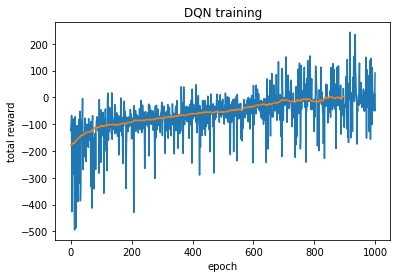

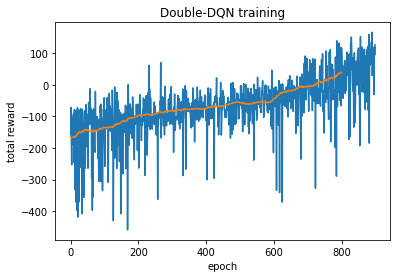

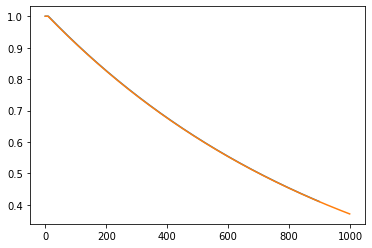

In [27]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n



plt.plot(dqn_ret)
plt.plot(moving_average(dqn_ret, n=100))
plt.xlabel('epoch')
plt.ylabel('total reward')
plt.title('DQN training')
plt.show()


plt.plot(ddqn_ret)
plt.plot(moving_average(ddqn_ret, n=100))
plt.xlabel('epoch')
plt.ylabel('total reward')
plt.title('Double-DQN training')
plt.show()

plt.plot(ddqn_eps)
plt.plot(dqn_eps)
plt.show()

### simulating environment

In [28]:
import time

def play(env, agent):
    done = False
    clear_output(wait=True)
    state = env.reset()
    env.render()
    
    while not done:
        action = agent.get_action(state, det=True)
        state, reward, done, info = env.step(action)
        
        clear_output(wait=True)
        print(info)
        env.render()
        time.sleep(0.5)
        
        


In [ ]:
play(env, dqn)

In [ ]:
play(env, ddqn)

### evaluating with deterministic policy

In [30]:
def evaluate_det_policy(env, agent, k=100):
    total_rewards = []
    for _ in range(k):
        done = False
        cum_r = 0
        state = env.reset()

        while not done:
            action = agent.get_action(state, det=True)
            state, reward, done, info = env.step(action)
            cum_r += reward
        
        total_rewards.append(cum_r)
    return total_rewards


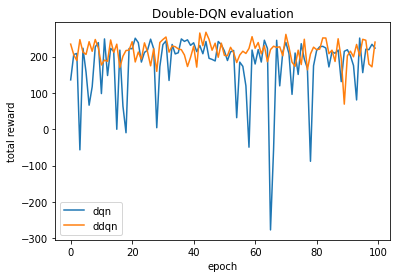

In [31]:
dqn_tot = evaluate_det_policy(env, dqn)
ddqn_tot = evaluate_det_policy(env, ddqn) 

plt.plot(dqn_tot)
plt.xlabel('epoch')
plt.ylabel('total reward')
plt.title('DQN evaluation')

plt.plot(ddqn_tot)
plt.xlabel('epoch')
plt.ylabel('total reward')
plt.title('Double-DQN evaluation')

plt.legend(['dqn', 'ddqn'])

plt.show()
